In [2]:
import os, math, gc, json, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
from pathlib import Path
DATASET_DIR = r"C:\Users\gfxsc\Desktop\Deep learning Datasets\fungal_classification"
assert 'DATASET_DIR' in globals(), "Please set DATASET_DIR to your dataset root."
for sub in ["train", "valid", "test"]:
    assert Path(DATASET_DIR, sub).is_dir(), f"Missing folder: {Path(DATASET_DIR, sub)}"

tf.keras.backend.clear_session(); gc.collect()

SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED)

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

EPOCHS_HEAD = 12        
EPOCHS_FT   = 28         
TOTAL_EPOCHS = EPOCHS_HEAD + EPOCHS_FT

BASE_LR_HEAD = 1e-3
BASE_LR_FT   = 1e-5
LABEL_SMOOTH = 0.1
DROPOUT      = 0.4
L2_WEIGHT    = 1e-4

print("Config OK.")



Config OK.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()
val_test_datagen = ImageDataGenerator()

train_dir = os.path.join(DATASET_DIR, "train")
valid_dir = os.path.join(DATASET_DIR, "valid")
test_dir  = os.path.join(DATASET_DIR, "test")

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=SEED
)
valid_generator = val_test_datagen.flow_from_directory(
    valid_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

NUM_CLASSES = train_generator.num_classes
idx_to_class = {v:k for k,v in train_generator.class_indices.items()}
class_names = [idx_to_class[i] for i in range(NUM_CLASSES)]
print("Classes:", class_names)

from collections import Counter
counts = Counter(train_generator.classes)
mx = max(counts.values())
CLASS_WEIGHTS = {cls: mx/cnt for cls, cnt in counts.items()}
print("Class weights (optional):", CLASS_WEIGHTS)


Found 5000 images belonging to 5 classes.
Found 899 images belonging to 5 classes.
Found 902 images belonging to 5 classes.
Classes: ['H1', 'H2', 'H3', 'H5', 'H6']
Class weights (optional): {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


In [4]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation")

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = layers.Lambda(preprocess_input, name="resnet50_preprocess")(x)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # Phase 1: frozen
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(DROPOUT)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(L2_WEIGHT))(x)
x = layers.Dropout(DROPOUT)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=regularizers.l2(L2_WEIGHT))(x)

model = models.Model(inputs, outputs)

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTH)
model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LR_HEAD), loss=loss, metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50_preprocess (Lambda)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
ckpt = ModelCheckpoint('best_resnet50_head_then_ft.keras', monitor='val_accuracy', mode='max',
                       save_best_only=True, verbose=1)
log = CSVLogger('resnet50_training_log.csv', append=True)

history_head = model.fit(
    train_generator,
    epochs=EPOCHS_HEAD,
    validation_data=valid_generator,
    callbacks=[reduce_lr, ckpt, log],
    class_weight=CLASS_WEIGHTS if CLASS_WEIGHTS else None
)


c:\Users\gfxsc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5570 - loss: 1.4238
Epoch 1: val_accuracy improved from None to 0.71635, saving model to best_resnet50_head_then_ft.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.6246 - loss: 1.2398 - val_accuracy: 0.7164 - val_loss: 1.0020 - learning_rate: 0.0010
Epoch 2/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7092 - loss: 1.0476
Epoch 2: val_accuracy did not improve from 0.71635
157/157 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.7042 - loss: 1.0424 - val_accuracy: 0.6941 - val_loss: 1.0321 - learning_rate: 0.0010
Epoch 3/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7377 - loss: 0.9989
Epoch 3: val_accuracy improved from 0.71635 to 0.74416, saving model to best_resnet50_head_then_ft.keras
157/157 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.7286 - loss: 1.0090 - val_accuracy: 0.7442 - val_loss: 0.9544 - learning_rate: 0.0010
Epoch 4/12
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy

In [6]:
for layer in base_model.layers:
    layer.trainable = layer.name.startswith('conv5_')

model.compile(optimizer=tf.keras.optimizers.Adam(BASE_LR_FT), loss=loss, metrics=['accuracy'])

history_ft = model.fit(
    train_generator,
    initial_epoch=EPOCHS_HEAD,
    epochs=TOTAL_EPOCHS,
    validation_data=valid_generator,
    callbacks=[reduce_lr, ckpt, log],
    class_weight=CLASS_WEIGHTS if CLASS_WEIGHTS else None
)

model.load_weights('best_resnet50_head_then_ft.keras')


Epoch 13/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6719 - loss: 1.1137
Epoch 13: val_accuracy did not improve from 0.78977
157/157 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.7076 - loss: 1.0451 - val_accuracy: 0.7742 - val_loss: 0.9324 - learning_rate: 1.0000e-05
Epoch 14/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7727 - loss: 0.9344
Epoch 14: val_accuracy did not improve from 0.78977
157/157 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.7770 - loss: 0.9282 - val_accuracy: 0.7864 - val_loss: 0.9057 - learning_rate: 1.0000e-05
Epoch 15/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7902 - loss: 0.8985
Epoch 15: val_accuracy did not improve from 0.78977
157/157 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.7936 - loss: 0.9036 - val_accuracy: 0.7875 - val_loss: 0.8931 - learning_rate: 1.0000e-05
Epoch 16/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8067 - loss: 0.8721
Epoch 16: val_accuracy improved from 0.78977 to 0.79310, savin

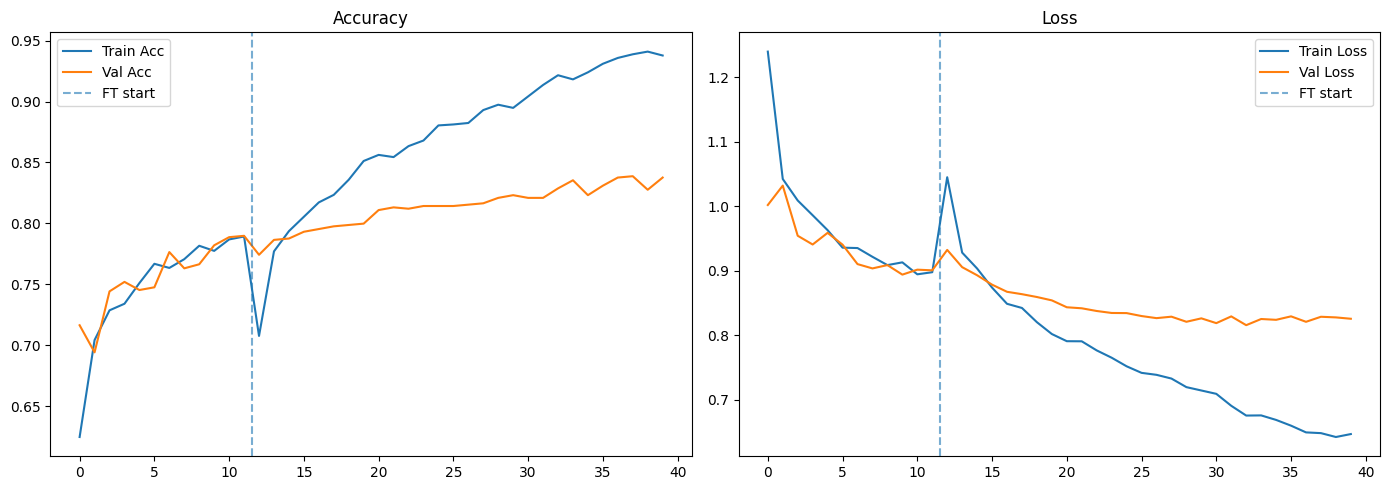

In [7]:
# ==== Cell 5: Plot training curves (merged) ====
def merge_histories(h1, h2):
    keys = set(h1.history.keys()) | set(h2.history.keys())
    merged = {k: list(h1.history.get(k, [])) + list(h2.history.get(k, [])) for k in keys}
    class H: pass
    H = H(); H.history = merged
    return H

def plot_training_history(history, ft_start_epoch=None):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs = range(len(acc))

    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    if ft_start_epoch is not None and len(acc) >= ft_start_epoch:
        plt.axvline(x=ft_start_epoch-0.5, ls='--', alpha=0.6, label='FT start')
    plt.legend(); plt.title('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    if ft_start_epoch is not None and len(loss) >= ft_start_epoch:
        plt.axvline(x=ft_start_epoch-0.5, ls='--', alpha=0.6, label='FT start')
    plt.legend(); plt.title('Loss'); plt.tight_layout(); plt.show()

merged_history = merge_histories(history_head, history_ft)
plot_training_history(merged_history, ft_start_epoch=EPOCHS_HEAD)


29/29 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step
Test Accuracy: 0.8248
Macro F1:      0.8566

Classification Report:
              precision    recall  f1-score   support

          H1     0.8226    0.8810    0.8508       437
          H2     0.7129    0.6395    0.6742       233
          H3     0.9067    0.8293    0.8662        82
          H5     0.9744    0.9500    0.9620        80
          H6     0.9167    0.9429    0.9296        70

    accuracy                         0.8248       902
   macro avg     0.8667    0.8485    0.8566       902
weighted avg     0.8227    0.8248    0.8226       902



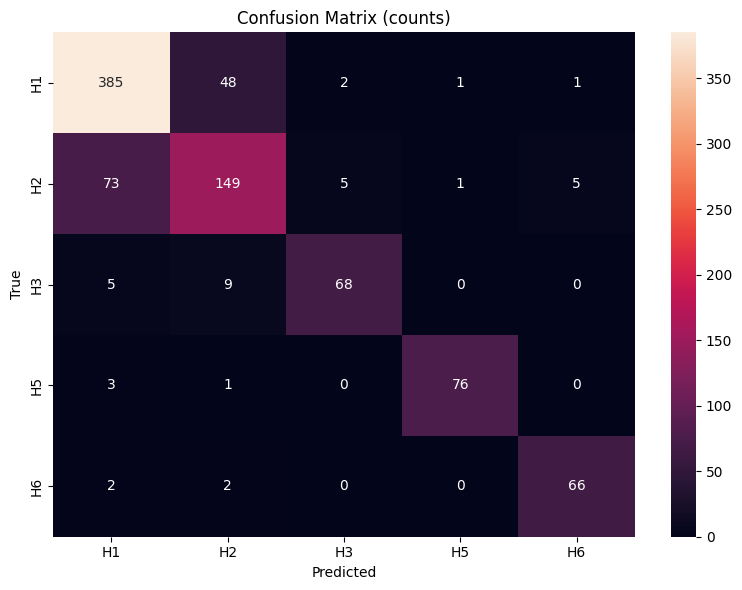

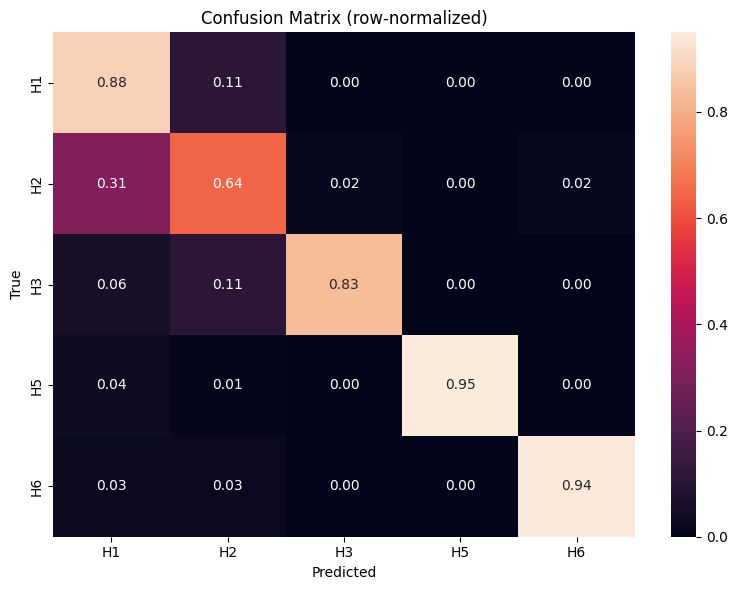

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

test_generator.reset()
steps = math.ceil(test_generator.samples / test_generator.batch_size)

Y_pred = model.predict(test_generator, steps=steps, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1:      {f1_score(y_true, y_pred, average='macro'):.4f}\n")

idx_to_class = {v:k for k,v in test_generator.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (counts)')
plt.tight_layout(); plt.show()

cm_norm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))), normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (row-normalized)')
plt.tight_layout(); plt.show()


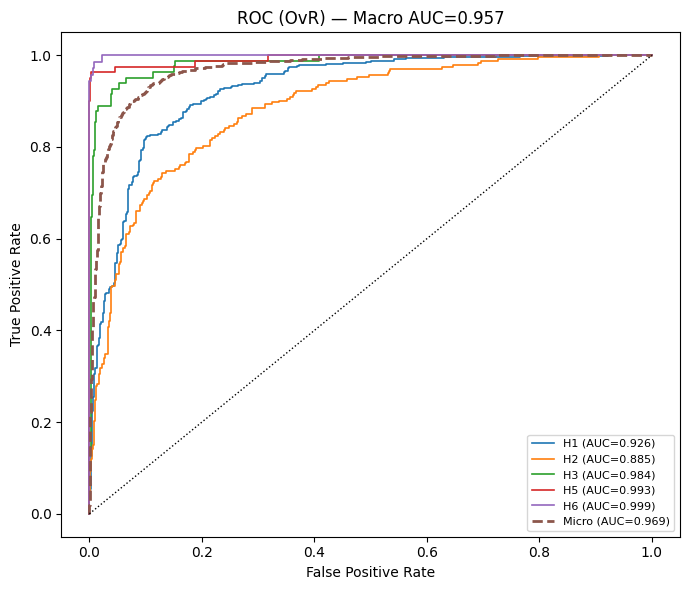

In [9]:
# ==== Cell 7: ROC curves (OvR) + micro/macro AUC ====
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

C = len(class_names)
y_true_oh = label_binarize(y_true, classes=list(range(C)))

per_class_auc = []
plt.figure(figsize=(7,6))
for i in range(C):
    fpr, tpr, _ = roc_curve(y_true_oh[:, i], Y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    per_class_auc.append(roc_auc)
    plt.plot(fpr, tpr, lw=1.2, label=f'{class_names[i]} (AUC={roc_auc:.3f})')

# Micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_true_oh.ravel(), Y_pred.ravel())
auc_micro = auc(fpr_micro, tpr_micro)
plt.plot(fpr_micro, tpr_micro, lw=2.0, ls='--', label=f'Micro (AUC={auc_micro:.3f})')

# Macro-average
auc_macro = np.mean(per_class_auc)
plt.plot([0,1],[0,1],'k:', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'ROC (OvR) — Macro AUC={auc_macro:.3f}')
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout(); plt.show()


In [10]:
model.save('resnet50_finetuned.keras')
with open('class_indices_resnet50.json', 'w') as f:
    json.dump(train_generator.class_indices, f, indent=2)
print("Saved: resnet50_finetuned.keras and class_indices_resnet50.json")



Saved: resnet50_finetuned.keras and class_indices_resnet50.json
